<a href="https://colab.research.google.com/github/reeruryu/VISIONEERS_study/blob/main/w05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

사전 훈련된 모델 다루기

# **8.1 텐서플로 허브**

In [2]:
# 텐서플로 허브에서 사전 훈련된 MobileNet 모델 불러오기
import tensorflow as tf
import tensorflow_hub as hub

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential([
    hub.KerasLayer(handle=mobile_net_url, input_shape=(224, 224, 3), trainable=False)                         
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [3]:
# ImageNetV2-TopImages 불러오기
import os
import pathlib
content_data_url = '/content/sample_data'
data_root_orig = tf.keras.utils.get_file('imagenetV2', 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-top-images.tar.gz', cache_dir=content_data_url, extract=True)
data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-top-images-format-val')
print(data_root)

1245937664/1245927936 [==============================] - 72s 0us/step
/content/sample_data/datasets/imagenetv2-top-images-format-val


In [4]:
# 디렉터리 출력
for idx, item in enumerate(data_root.iterdir()):
    print(item)
    if idx == 9:
        break

/content/sample_data/datasets/imagenetv2-top-images-format-val/307
/content/sample_data/datasets/imagenetv2-top-images-format-val/291
/content/sample_data/datasets/imagenetv2-top-images-format-val/530
/content/sample_data/datasets/imagenetv2-top-images-format-val/981
/content/sample_data/datasets/imagenetv2-top-images-format-val/581
/content/sample_data/datasets/imagenetv2-top-images-format-val/712
/content/sample_data/datasets/imagenetv2-top-images-format-val/236
/content/sample_data/datasets/imagenetv2-top-images-format-val/767
/content/sample_data/datasets/imagenetv2-top-images-format-val/49
/content/sample_data/datasets/imagenetv2-top-images-format-val/353


In [4]:
# ImageNet 라벨 텍스트 불러오기
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_text = None
with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

24576/10484 [======================================================================] - 0s 0us/step
1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


image_count: 10000


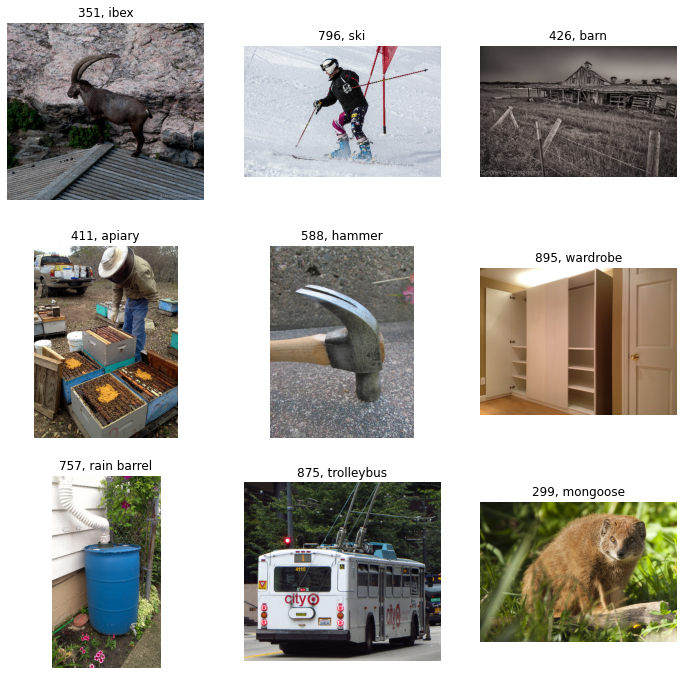

In [5]:
# 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

# 이미지를 랜덤하게 섞습니다
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12,12))
for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1 # background 때문에 +1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
plt.show()

In [6]:
# MobileNet의 분류 성능 확인
import cv2
import numpy as np

top_1 = 0
top_5 = 0
for image_path in all_image_paths:
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize=(224, 224))
  img = img / 255.0
  img = np.expand_dims(img, axis=0)
  top_5_predict = model.predict(img)[0].argsort()[::-1][:5]
  idx = int(image_path.split('/')[-2])+1
  if idx in top_5_predict:
    top_5 += 1
    if top_5_predict[0] == idx:
      top_1 += 1

print('Top-5 correctness:', top_5 / len(all_image_paths) * 100, '%')
print('Top-1 correctness:', top_1 / len(all_image_paths) * 100, '%')

KeyboardInterrupt: ignored

In [ ]:
# numpy.argsort() 설명 코드
a = np.array([99,32,5,64])
arg = np.argsort(a)
print(arg)
print(np.sort(a))
print(a[arg])

[2 1 3 0]
[ 5 32 64 99]
[ 5 32 64 99]


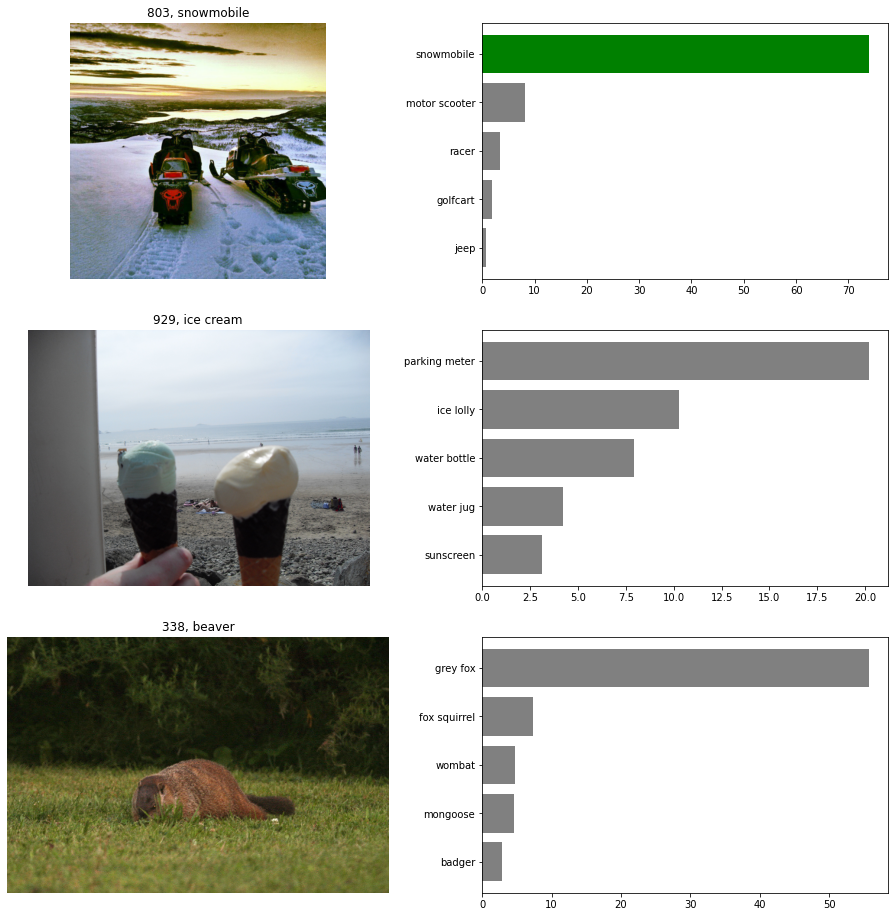

In [7]:
# MobileNet의 분류 라벨 확인
plt.figure(figsize=(16,16))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
  
for c in range(3):
    image_path = random.choice(all_image_paths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # MobileNet을 이용한 예측
    logits = model.predict(img)[0]
    prediction = softmax(logits)
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [label_text[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])    


# **8.2 전이학습**

## **8.2.1 모델의 일부를 재학습시키기**

In [25]:
# kaggle API를 설치합니다.
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# 2020.02.01 현재 kaggle의 Stanford Dog Dataset 파일 구조가 변경됨
# kaggle API를 사용하는 대신에 아래 링크에서 파일을 직접 받아오도록 수정됨
tf.keras.utils.get_file('/content/labels.csv', 'http://bit.ly/2GDxsYS')
tf.keras.utils.get_file('/content/sample_submission.csv', 'http://bit.ly/2GGnMNd')
tf.keras.utils.get_file('/content/train.zip', 'http://bit.ly/31nIyel')
tf.keras.utils.get_file('/content/test.zip', 'http://bit.ly/2GHEsnO')

# Stanford Dog Dataset을 Kaggle에서 불러오기
'''
import os
os.environ['KAGGLE_USERNAME'] = 'ryureeru' # 캐글 ID
os.environ['KAGGLE_KEY'] = '69c223ace62511a4bb0d63e7db6fa380' # 캐글 API Token
## !kaggle competitions download -c dog-breed-identification
'''

"\nimport os\nos.environ['KAGGLE_USERNAME'] = 'ryureeru' # 캐글 ID\nos.environ['KAGGLE_KEY'] = '69c223ace62511a4bb0d63e7db6fa380' # 캐글 API Token\n## !kaggle competitions download -c dog-breed-identification\n"

In [9]:
# 파일의 압축 풀기
!unzip train.zip
# !unzip labels.csv.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/841463629c4833816

In [10]:
# labels.csv 파일 내용 확인
import pandas as pd
label_text = pd.read_csv('labels.csv')
print(label_text.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
# labels.csv 정보 확인
label_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [ ]:
# 견종 수 확인
label_text['breed'].nunique()

120

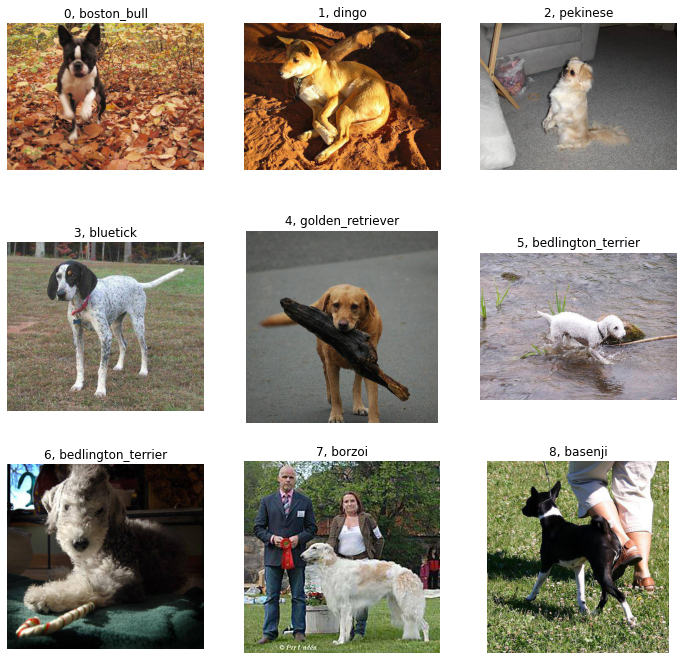

In [ ]:
# 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for c in range(9):
    image_id = label_text.loc[c, 'id']
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread('/content/train/' + image_id + '.jpg'))
    plt.title(str(c) + ', ' + label_text.loc[c, 'breed'])
    plt.axis('off')
plt.show()

In [11]:
# tf.keras에서 MobileNet V2 불러오기
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

14548992/14536120 [==============================] - 0s 0us/step


In [14]:
# MobileNet V2의 가중치 초기화
for layer in mobilev2.layers[:-1]:
    layer.trainable = True
    
for layer in mobilev2.layers[:-1]: 
    if 'kernel' in layer.__dict__:
        kernel_shape = np.array(layer.get_weights()).shape
        # weight를 평균이 0, 표준편차가 1인 random 변수로 초기화
        layer.set_weights(tf.random.normal(kernel_shape, 0, 1))     

In [6]:
## train 데이터를 메모리에 로드
# import cv2

# train_X = []
# for i in range(len(label_text)):
#     img = cv2.imread('/content/train/' + label_text['id'][i] + '.jpg')
#     img = cv2.resize(img, dsize=(224, 224))
#     img = img / 255.0
#     train_X.append(img)
# train_X = np.array(train_X)
# print(train_X.shape)
# print(train_X.size * train_X.itemsize, ' bytes')

# 2020.04.08 수정된 부분입니다.
# 예제 8.16은 고용량 RAM 모드를 지원하지 않는 무료 버전의 경우 OOM(Out Of Memory) 문제를 일으키기 때문에 주석처리합니다.
# 대신에 예제 8.24와 8.25를 이용해서 ImageDataGenerator로 학습을 시킵니다.

# 8.24 ImageDataGenerator가 처리할 수 있는 하위 디렉토리 구조로 데이터 복사
import os
import shutil

#os.mkdir('/content/train_sub')

for i in range(len(label_text)):
    if os.path.exists('/content/train_sub/' + label_text.loc[i]['breed']) == False:
        os.mkdir('/content/train_sub/' + label_text.loc[i]['breed'])
    shutil.copy('/content/train/' + label_text.loc[i]['id'] + '.jpg', '/content/train_sub/' + label_text.loc[i]['breed'])

# 8.25 ImageDataGenerator를 이용한 train/validation 데이터 분리, Image Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 224 # 이미지 사이즈가 299에서 224로 바뀌었습니다.
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., horizontal_flip=True, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, validation_split=0.25)
valid_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

train_generator = train_datagen.flow_from_directory(directory="/content/train_sub/", subset="training", batch_size=batch_size, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))
valid_generator = valid_datagen.flow_from_directory(directory="/content/train_sub/", subset="validation", batch_size=1, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))

NameError: ignored

In [19]:
# train 라벨 데이터를 메모리에 로드
unique_Y = label_text['breed'].unique().tolist()
train_Y = [unique_Y.index(breed) for breed in label_text['breed']]
train_Y = np.array(train_Y)

print(train_Y[:10])
print(train_Y[-10:])

[0 1 2 3 4 5 5 6 7 8]
[34 87 91 63 48  6 93 63 77 92]


In [38]:
# Dogs Dataset 학습을 위한 모델 정의
x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # 라벨이 원-핫 인코딩을 사용하기 때문에 sparse가 아닌 categorical_crossentropy를 사용
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [5]:
# 랜덤한 가중치를 가진 상태에서의 학습
history = model.fit(train_X, train_Y, epochs=10, validation_split=0.25, batch_size=32)
# teps_per_epoch = int(7718/32) # generator를 사용하기 때문에 1epoch 당 학습할 step수를 정합니다. batch_size인 32로 train_data의 크기를 나눠주면 됩니다.
# history = model.fit_generator(train_generator, validation_data=valid_generator, epochs=10, steps_per_epoch=steps_per_epoch) # model.fit_generator()를 사용합니다.

NameError: ignored

In [ ]:
# 학습 결과 확인
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 0.1)
plt.legend()

plt.show()

In [3]:
# Dogs Dataset 학습을 위한 Transfer Learning 모델 정의
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

# 뒤에서 20개까지의 레이어는 훈련 가능, 나머지는 가중치 고정
for layer in model.layers[:-20]:
    layer.trainable = False
for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # 라벨이 원-핫 인코딩을 사용하기 때문에 sparse가 아닌 categorical_crossentropy를 사용합니다.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
# 모델 학습 및 결과 확인
history = model.fit(train_X, train_Y, epochs=10, validation_split=0.25, batch_size=32)
# steps_per_epoch = int(7718/32) # generator를 사용하기 때문에 1epoch 당 학습할 step수를 정합니다. batch_size인 32로 train_data의 크기를 나눠주면 됩니다.
# history = model.fit_generator(train_generator, validation_data=valid_generator, epochs=10, steps_per_epoch=steps_per_epoch) # model.fit_generator()를 사용합니다.

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.3, 1)
plt.legend()

plt.show()

## **8.2.2 특징 추출기**

In [4]:
# 텐서플로우 허브에서 사전 훈련된 Inception V3의 특징 추출기 불러오기
import tensorflow_hub as hub

inception_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(inception_url, output_shape=(2048,), trainable=False)
])
feature_model.build([None, 299, 299, 3])
feature_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


In [11]:
# ImageDataGenerator가 처리할 수 있는 하위 디렉토리 구조로 데이터 복사
import os
import shutil

# os.mkdir('/content/train_sub')

for i in range(len(label_text)):
    if os.path.exists('/content/train_sub/' + label_text.loc[i]['breed']) == False:
        os.mkdir('/content/train_sub/' + label_text.loc[i]['breed'])
    shutil.copy('/content/train/' + label_text.loc[i]['id'] + '.jpg', '/content/train_sub/' + label_text.loc[i]['breed'])

In [12]:
# ImageDataGenerator를 이용한 train/validation 데이터 분리, Image Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 299
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., horizontal_flip=True, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, validation_split=0.25)
valid_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

train_generator = train_datagen.flow_from_directory(directory="/content/train_sub/", subset="training", batch_size=batch_size, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))
valid_generator = valid_datagen.flow_from_directory(directory="/content/train_sub/", subset="validation", batch_size=1, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))

Found 7718 images belonging to 120 classes.
Found 2504 images belonging to 120 classes.


In [14]:
# train 데이터를 특징 벡터로 변환

import numpy as np

batch_step = (7718 * 3) // batch_size
train_features = []
train_Y = []
for idx in range(batch_step):
    if idx % 100 == 0:
        # print(idx)
    x, y = train_generator.next()
    train_Y.extend(y)
    
    feature = feature_model.predict(x)
    train_features.extend(feature)

train_features = np.array(train_features)
train_Y = np.array(train_Y)
print(train_features.shape)
print(train_Y.shape)

(23084, 2048)
(23084, 120)


In [15]:
# validation 데이터를 특징 벡터로 변환
valid_features = []
valid_Y = []

for idx in range(valid_generator.n):
    if idx % 100 == 0:
        print(idx)
    x, y = valid_generator.next()
    valid_Y.extend(y)
    
    feature = feature_model.predict(x)
    valid_features.extend(feature)

valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)
print(valid_features.shape)
print(valid_Y.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
(2504, 2048)
(2504, 120)


In [16]:
# 분류를 위한 작은 Sequential 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(2048,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax')
])

model.compile(tf.optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 120)               30840     
                                                                 
Total params: 555,384
Trainable params: 555,384
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
722/722 [==============================] - 7s 6ms/step - loss: 2.8225 - accuracy: 0.4534 - val_loss: 0.8992 - val_accuracy: 0.8626
Epoch 2/10
722/722 [==============================] - 2s 3ms/step - loss: 0.9241 - accuracy: 0.7821 - val_loss: 0.4266 - val_accuracy: 0.8886
Epoch 3/10
722/722 [==============================] - 2s 3ms/step - loss: 0.6170 - accuracy: 0.8292 - val_loss: 0.3503 - val_accuracy: 0.8982
Epoch 4/10
722/722 [==============================] - 3s 3ms/step - loss: 0.5090 - accuracy: 0.8515 - val_loss: 0.3225 - val_accuracy: 0.8986
Epoch 5/10
722/722 [==============================] - 2s 3ms/step - loss: 0.4472 - accuracy: 0.8647 - val_loss: 0.3085 - val_accuracy: 0.9014
Epoch 6/10
722/722 [==============================] - 2s 3ms/step - loss: 0.4010 - accuracy: 0.8779 - val_loss: 0.3072 - val_accuracy: 0.9014
Epoch 7/10
722/722 [==============================] - 3s 3ms/step - loss: 0.3701 - accuracy: 0.8846 - val_loss: 0.2983 - val_accuracy: 0.9038
Epoch 

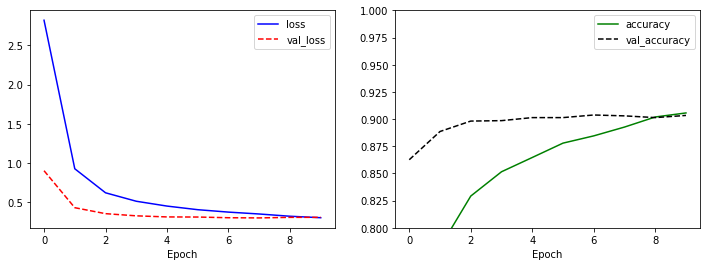

In [17]:
# 분류를 위한 작은 Sequential 모델 학습
history = model.fit(train_features, train_Y, validation_data=(valid_features, valid_Y), epochs=10, batch_size=32)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 1)
plt.legend()

plt.show()

In [20]:
# 라벨 텍스트를 알파벳 순으로 정렬
unique_sorted_Y = sorted(unique_Y)
print(unique_sorted_Y)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

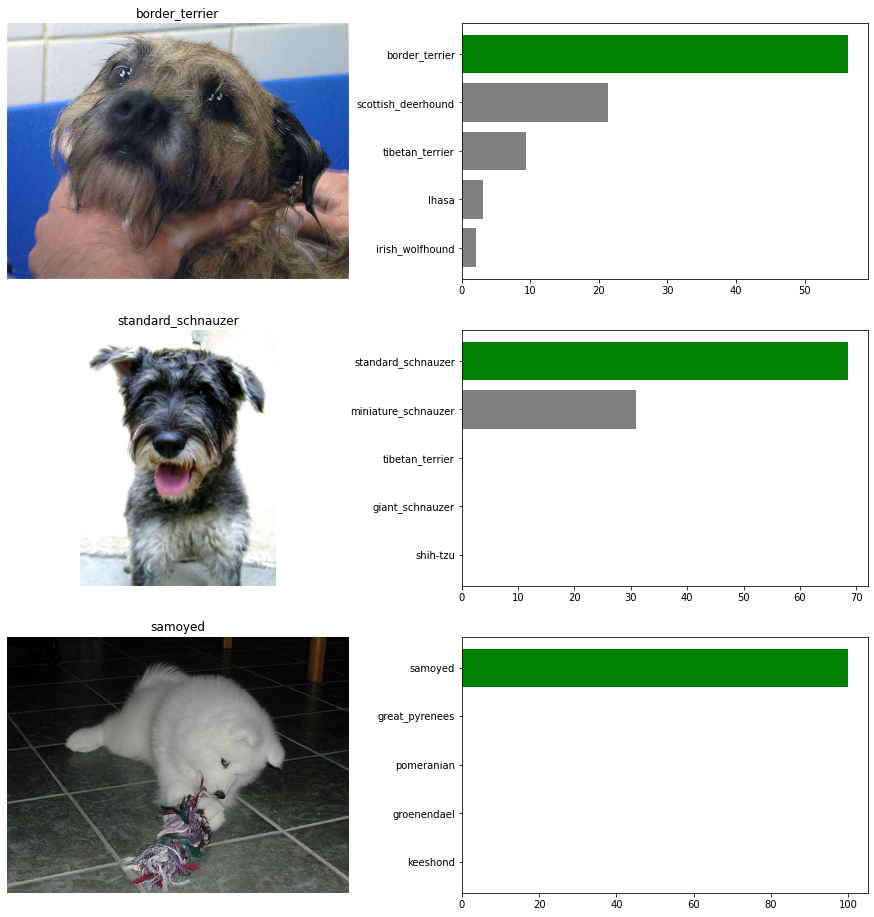

In [22]:
# Inception V3 특징 추출기-Sequential 모델의 분류 라벨 확인
import random
import cv2

plt.figure(figsize=(16,16))
  
for c in range(3):
    image_path = random.choice(valid_generator.filepaths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    real_y = image_path.split('/')[3]
    plt.title(real_y)
    plt.axis('off')
    idx = unique_sorted_Y.index(real_y)
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(299, 299))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Inception V3를 이용한 특징 벡터 추출
    feature_vector = feature_model.predict(img)
    
    # Sequential 모델을 이용한 예측
    prediction = model.predict(feature_vector)[0]
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [unique_sorted_Y[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])

In [23]:
# test 데이터의 압축 풀기
!unzip test.zip
!unzip sample_submission.csv.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: test/82e41a906dbd9ec362a3d49cf6bbe645.jpg  
  inflating: test/82e5e34cc18b267ef7057cc92de8b44b.jpg  
  inflating: test/82e64f28df4fff22beb11e9a1e413212.jpg  
  inflating: test/82ec6bdf968a14923340179515ce5546.jpg  
  inflating: test/82ee3ee4dc01b33203a049c6c3338034.jpg  
  inflating: test/82f07a63a1f03ff9d8e0f4a8458caa93.jpg  
  inflating: test/82f5fb0bdaff30a4a3374e2d9915856c.jpg  
  inflating: test/82fbff1bd375474e3d4ec5cbfde3f9f0.jpg  
  inflating: test/8301c772feb7f4068473f0157ae58f9b.jpg  
  inflating: test/8307be57a9d76c1584e16801a39cb1dc.jpg  
  inflating: test/831a38bd2cfa0a093967d5b6c1ac09dc.jpg  
  inflating: test/831ef824af939f9754e3593638933b64.jpg  
  inflating: test/8322f53b29325419ef3bcf7cf10d7172.jpg  
  inflating: test/83233e2774e116ef34a04c53dd00a282.jpg  
  inflating: test/832cae23410e741ecd2014b3818ed7c4.jpg  
  inflating: test/833f90a3652b06607b55bd25c8d97457.jpg  
  inflating: test/8341f50a86c819b3cb8828740a97e7ef.j

In [24]:
# submission.csv 파일 내용 확인
import pandas as pd
submission = pd.read_csv('sample_submission.csv')
print(submission.head())
print()
print(submission.info())

                                 id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.008333      0.008333   
1  00102ee9d8eb90812350685311fe5890       0.008333      0.008333   
2  0012a730dfa437f5f3613fb75efcd4ce       0.008333      0.008333   
3  001510bc8570bbeee98c8d80c8a95ec1       0.008333      0.008333   
4  001a5f3114548acdefa3d4da05474c2e       0.008333      0.008333   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.008333  0.008333                        0.008333     0.008333   
1             0.008333  0.008333                        0.008333     0.008333   
2             0.008333  0.008333                        0.008333     0.008333   
3             0.008333  0.008333                        0.008333     0.008333   
4             0.008333  0.008333                        0.008333     0.008333   

   australian_terrier   basenji    basset  ...  toy_poodle  toy_terrier  \
0            0.008333  0.0083

In [25]:
# ImageDataGenerator가 처리할 수 있는 하위 디렉토리 구조로 데이터 복사
import os
import shutil

os.mkdir('/content/test_sub/')
os.mkdir('/content/test_sub/unknown/')

for i in range(len(submission)):
    shutil.copy('/content/test/' + submission.loc[i]['id'] + '.jpg', '/content/test_sub/unknown/')

In [26]:
# ImageDataGenerator를 이용한 test 데이터 불러오기
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_directory(directory="/content/test_sub/",batch_size=1,seed=42,shuffle=False,target_size=(299, 299))

Found 10357 images belonging to 1 classes.


In [27]:
# test 데이터를 특징 벡터로 변환
test_features = []

for idx in range(test_generator.n):
    if idx % 100 == 0:
        print(idx)
        
    x, _ = test_generator.next()
    feature = feature_model.predict(x)
    test_features.extend(feature)

test_features = np.array(test_features)
print(test_features.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
(10357, 2048)


In [28]:
# 특징 벡터로 test 데이터의 정답 예측
test_Y = model.predict(test_features, verbose=1)

324/324 [==============================] - 1s 2ms/step


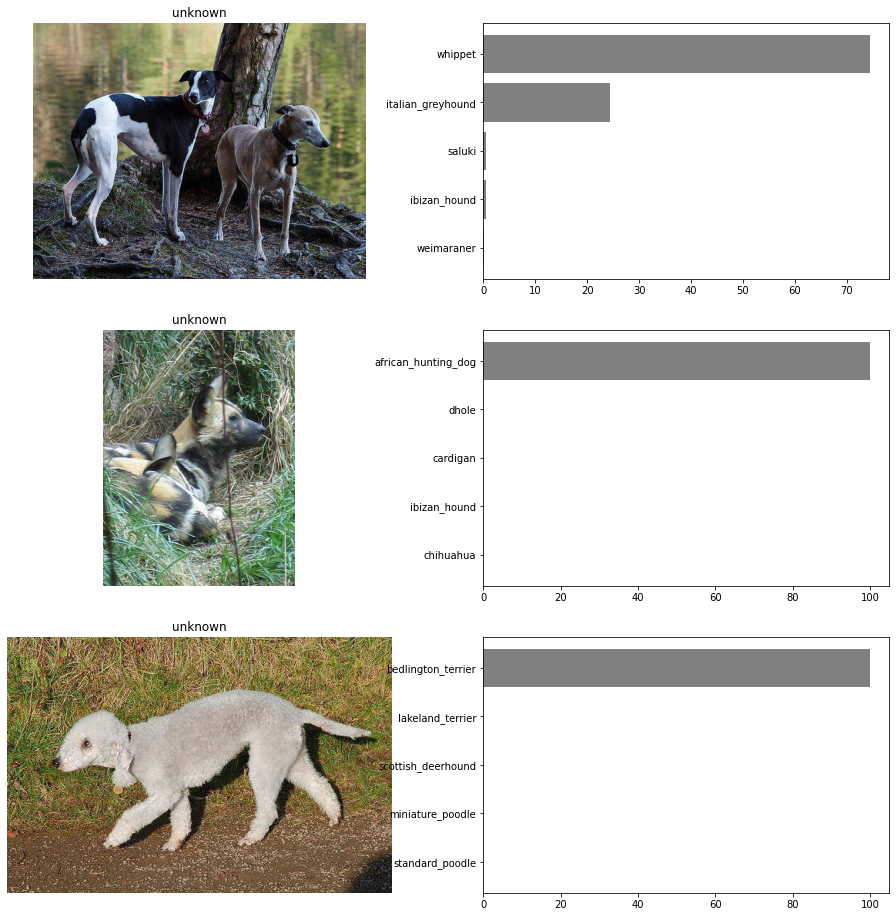

In [29]:
# Inception V3 특징 추출기-Sequential 모델의 test 데이터 분류 라벨 확인
import random
plt.figure(figsize=(16,16))
  
for c in range(3):
    image_path = random.choice(test_generator.filepaths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    real_y = image_path.split('/')[3]
    plt.title(real_y)
    plt.axis('off')
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(299, 299))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Inception V3를 이용한 특징 벡터 추출
    feature_vector = feature_model.predict(img)
    
    # Sequential 모델을 이용한 예측
    prediction = model.predict(feature_vector)[0]
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [unique_sorted_Y[index] for index in top_5_predict]
    color = ['gray'] * 5
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])

In [30]:
# submission 데이터프레임에 예측값 저장
for i in range(len(test_Y)):
    for j in range(len(test_Y[i])):
        breed_column = unique_sorted_Y[j]
        submission.loc[i, breed_column] = test_Y[i, j]

In [31]:
# submission 데이터 확인
print(submission.iloc[:5, :5])

                                 id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e   7.894868e-07  2.359886e-07   
1  00102ee9d8eb90812350685311fe5890   8.080514e-08  3.242816e-08   
2  0012a730dfa437f5f3613fb75efcd4ce   1.191438e-06  2.440182e-03   
3  001510bc8570bbeee98c8d80c8a95ec1   1.566117e-05  9.069507e-08   
4  001a5f3114548acdefa3d4da05474c2e   3.873227e-02  2.954709e-05   

   african_hunting_dog      airedale  
0         4.862259e-09  3.863326e-07  
1         1.313714e-07  2.743509e-07  
2         2.907651e-06  6.657310e-06  
3         2.357385e-07  2.054004e-07  
4         3.193021e-06  3.580189e-07  


In [32]:
# submission 데이터프레임을 csv 파일로 저장
submission.to_csv('dogbreed_submission_inceptionV3_epoch10_299.csv', index=False)